In [107]:
%matplotlib inline
import numpy as np
import pandas as pd
from pandas import DataFrame
from geopandas import GeoDataFrame
import matplotlib.pyplot as plt
import geopandas as gp
import zipfile
import os

In [108]:
os.getenv('PUIDATA')

'/home/cusp/jc7344/PUIdata'

In [109]:
shape_path="/home/cusp/jc7344/PUI2016_fb55/Lab9_SRK325/Data/CT_Shape"
ct_shape = GeoDataFrame.from_file(shape_path)
ct_shape.index=ct_shape.BoroCT2010

In [110]:
from fiona.crs import from_epsg
ct_shape.crs = from_epsg(4326) # epsg=4326: lat/on | 26918: NAD83/UTM zone 18N | epsg=2263 is US feet
NYC_Area=ct_shape.to_crs(epsg=2263).geometry.area.sum()/(2.788*10**7) # from ft2 to mi2 
print 'total NYC land area: %s (mi^2)'%str(NYC_Area)[:5] # from ft2 to mi2 #epsg=2263 is US feet

total NYC land area: 302.3 (mi^2)


### Visualizing Census tract Shapefile

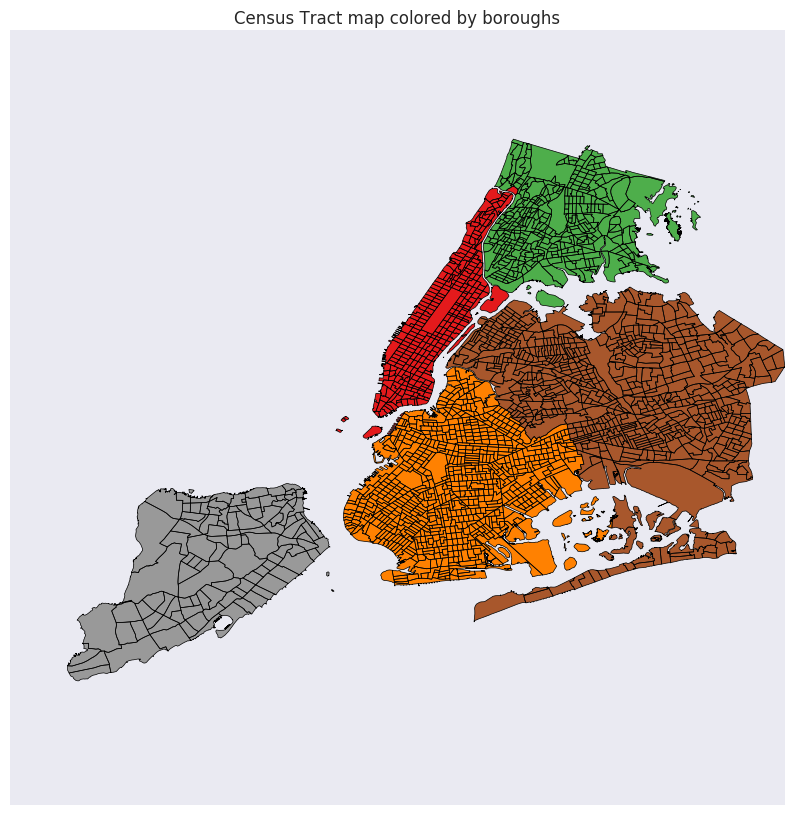

In [111]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape.plot(column='BoroCode',alpha=1,linewidth=0.5,ax=ax)
plt.title("Census Tract map colored by boroughs")

The map above displays five boroughs having cencus tract as the geographic unit

## Map NYC Population density
### Load Census Data for 2010

In [112]:
ct_data=DataFrame.from_csv(os.getenv("PUIDATA")+ "/" + 'ACS_CT2010.csv')
#set index to be the BoroCT2010 code
ct_data.index=ct_data.BoroCT2010.astype(str)

### Add popuation density to CT shapefile

In [113]:
ct_shape_pop=ct_shape.join(ct_data[['SE_T002_002']]) #SE_T002_002 is population density in social explorer dataset

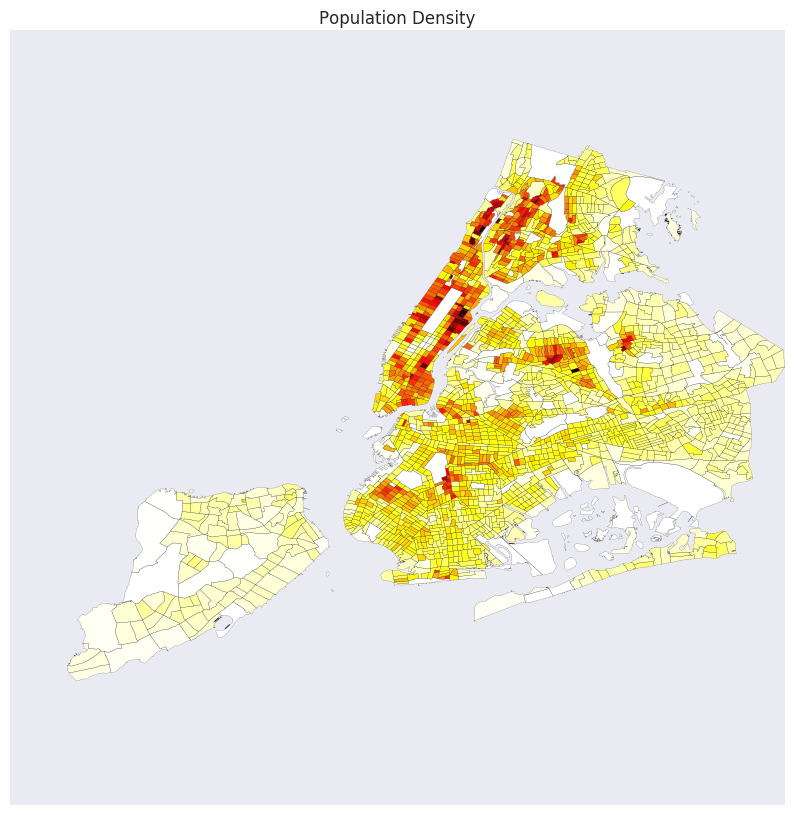

In [114]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape_pop.plot(column='SE_T002_002',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax)
plt.title("Population Density")

The map above plots the population density by census tract in NYC

## Explore CitiBike data
### Load CitiBike data

In [115]:
df_bike_monthly=DataFrame.from_csv(os.getenv("PUIDATA")+ "/" + 'CitiBike_monthly_byStation.csv')
df_bike_monthly.head()

,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,...,1533,1534,1535,1536,1537,1538,1539,1540,1541,1542
starttime,,,,,,,,,,,,,,,,,,,,,
2013-07-31,2343,3914,6979,2750,4914,2229,2183,3139,3622,2368,...,0,0,0,0,0,0,0,0,0,0
2013-08-31,2696,4429,9020,3433,6645,2768,2761,3422,4271,2910,...,0,0,0,0,0,0,0,0,0,0
2013-09-30,2878,5258,9814,3739,7837,3206,2747,3590,4618,2885,...,0,0,0,0,0,0,0,0,0,0
2013-10-31,2920,4409,10456,3520,8928,3237,2530,3909,4169,2542,...,0,0,0,0,0,0,0,0,0,0
2013-11-30,1883,2731,6384,2446,5201,2085,1415,2727,3146,1539,...,0,0,0,0,0,0,0,0,0,0


### Split data into to groups for winter and summer, respectively. 

In [116]:
df_bike_monthly['Month'] = df_bike_monthly.index.month

In [117]:
summer_ride = df_bike_monthly[(df_bike_monthly['Month']>=6) & (df_bike_monthly['Month']<=8)]
summer_ride

,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,...,1534,1535,1536,1537,1538,1539,1540,1541,1542,Month
starttime,,,,,,,,,,,,,,,,,,,,,
2013-07-31,2343,3914,6979,2750,4914,2229,2183,3139,3622,2368,...,0,0,0,0,0,0,0,0,0,7
2013-08-31,2696,4429,9020,3433,6645,2768,2761,3422,4271,2910,...,0,0,0,0,0,0,0,0,0,8
2014-06-30,2048,3306,9626,3515,7255,2942,1917,3702,3694,2422,...,0,0,0,0,0,0,0,0,0,6
2014-07-31,2252,3216,9825,3509,7014,3224,2195,3732,4042,2268,...,0,0,0,0,0,0,0,0,0,7
2014-08-31,2179,3004,10196,3573,7328,3311,2213,4078,4011,2168,...,0,0,0,0,0,0,0,0,0,8
2015-06-30,2309,0,9457,3426,5859,4763,1809,5190,2695,2116,...,0,0,0,0,0,0,0,0,0,6
2015-07-31,2556,3831,10341,3958,6424,5397,2185,5688,4846,2743,...,0,0,0,0,0,0,0,0,0,7
2015-08-31,2640,3799,11801,4288,7031,5417,2470,6306,4583,2838,...,0,0,0,0,0,0,0,0,0,8
2016-06-30,3399,7370,10130,4566,7420,5775,2429,6037,0,3054,...,0,0,7009,1109,665,2470,178,852,615,6


In [118]:
winter_ride = df_bike_monthly[(df_bike_monthly['Month']>=12) | (df_bike_monthly['Month']<=2)]
winter_ride

,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,...,1534,1535,1536,1537,1538,1539,1540,1541,1542,Month
starttime,,,,,,,,,,,,,,,,,,,,,
2013-12-31,1299,1650,4081,1686,3046,1575,830,1890,2048,1009,...,0,0,0,0,0,0,0,0,0,12
2014-01-31,956,1337,3178,1251,1920,1130,477,1412,1082,681,...,0,0,0,0,0,0,0,0,0,1
2014-02-28,650,960,2920,676,1808,933,508,1045,963,530,...,0,0,0,0,0,0,0,0,0,2
2014-12-31,1052,1304,4501,1783,2985,2091,779,2108,1636,878,...,0,0,0,0,0,0,0,0,0,12
2015-01-31,833,0,3186,1248,1992,1429,442,1499,1366,619,...,0,0,0,0,0,0,0,0,0,1
2015-02-28,562,0,2130,913,1363,1140,356,1023,891,447,...,0,0,0,0,0,0,0,0,0,2
2015-12-31,1873,2502,7101,2678,3968,3492,1420,3620,3251,1654,...,0,0,0,0,0,0,0,0,0,12
2016-01-31,1031,1669,4533,1847,2304,1943,656,2485,0,935,...,0,0,0,0,0,0,0,0,0,1
2016-02-29,1200,1951,4913,2088,2503,2224,859,2814,0,1082,...,0,0,0,0,0,0,0,0,0,2


### Time series analysis for both seasons

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:7: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.


(-200, 16000)

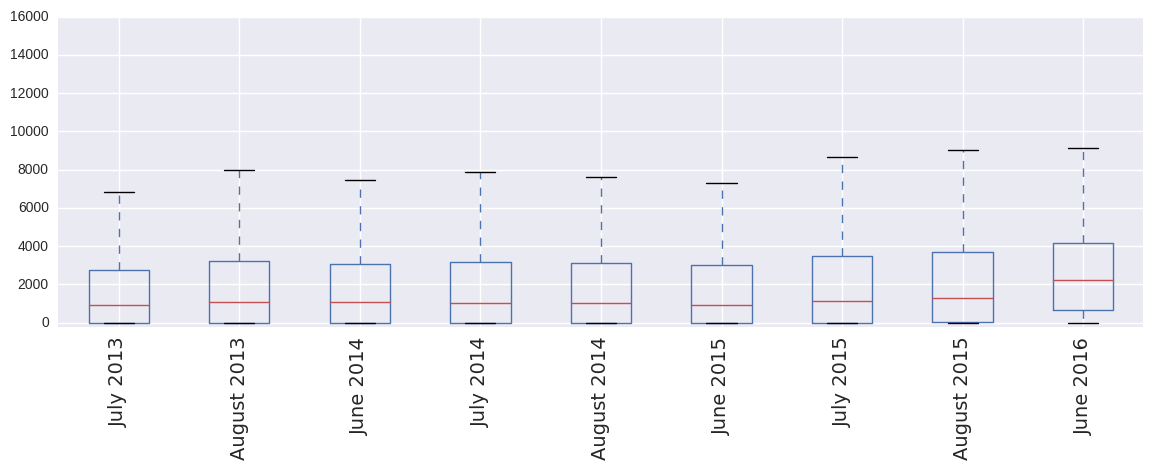

In [119]:
#Summer 
plt.rcParams['font.size']=14
f, ax = plt.subplots(figsize=(14,4))
#create a copy of the df for the viz purposes
df_bike_monthly_=summer_ride.copy()
df_bike_monthly_.index=df_bike_monthly_.index.strftime("%B %Y")
df_bike_monthly_.T.boxplot(figsize=(15,7),ax=ax,rot=90);
ax.set_ylim([-200,16000])

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:7: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.


(-200, 16000)

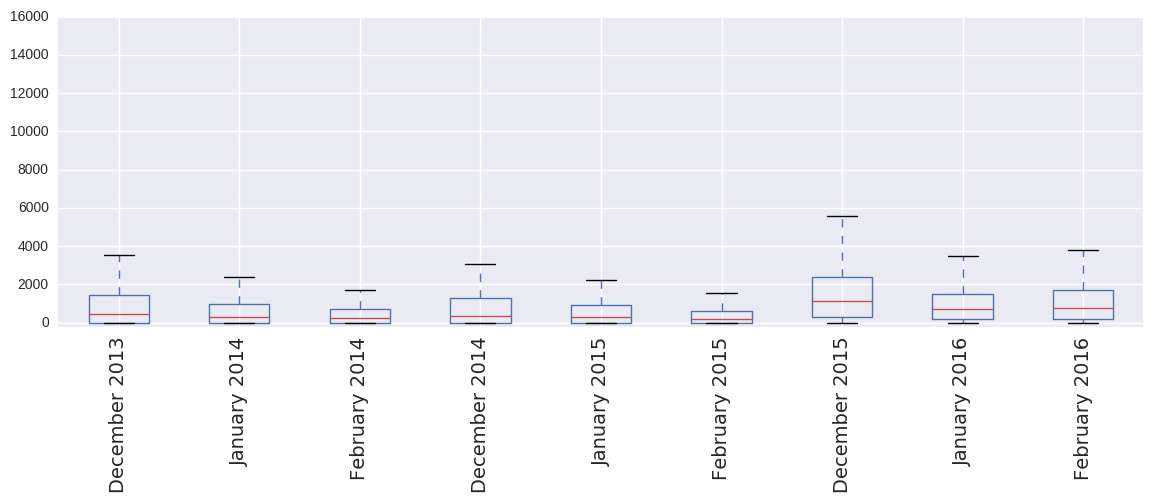

In [120]:
#Winter
plt.rcParams['font.size']=14
f, ax = plt.subplots(figsize=(14,4))
#create a copy of the df for the viz purposes
df_bike_monthly_=winter_ride.copy()
df_bike_monthly_.index=df_bike_monthly_.index.strftime("%B %Y")
df_bike_monthly_.T.boxplot(figsize=(15,7),ax=ax,rot=90);
ax.set_ylim([-200,16000])

### Seasonal decomposition (Summer and Winter)

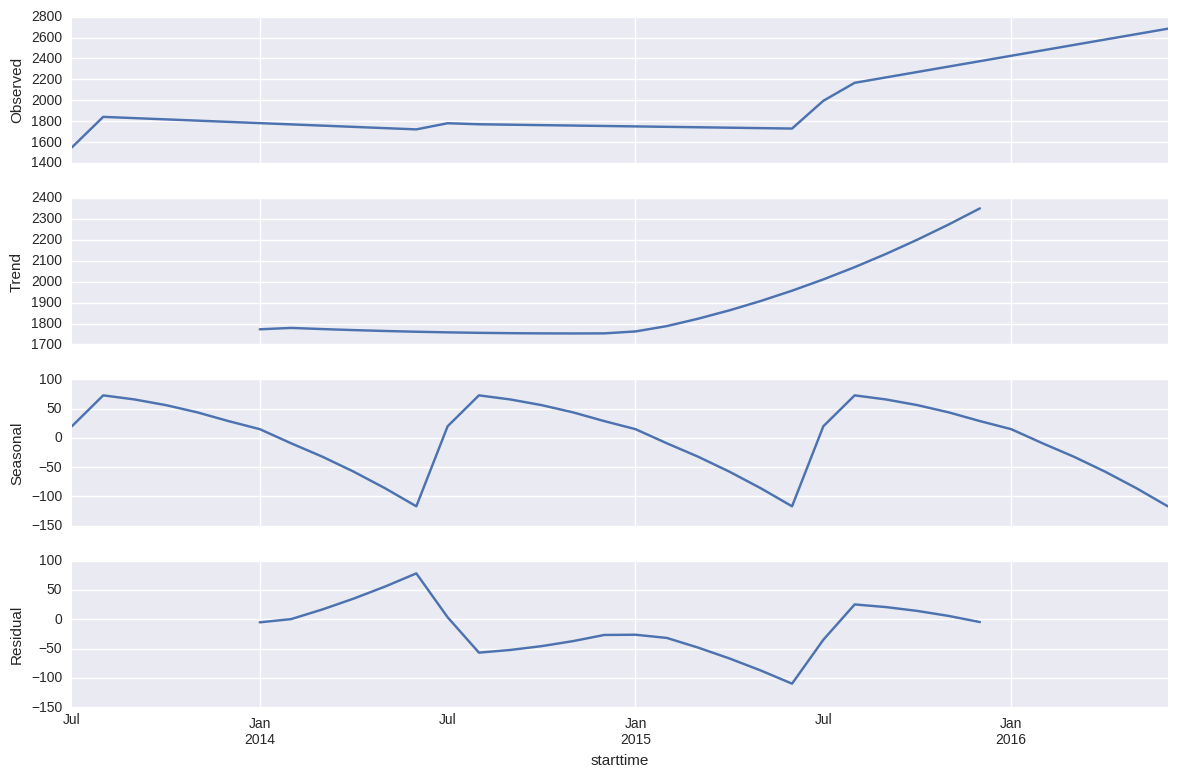

In [121]:
#Summer
import statsmodels.api as sm

#Create a monthly time series of bike ride (Average of all citibike stations)
df_new=summer_ride.mean(1).resample('M').mean()
df_new.interpolate(inplace=True)

#Seasonal Decomposition using statsmodels api
res = sm.tsa.seasonal_decompose(df_new.dropna())
plt.rcParams['figure.figsize']=(12,8)
resplot = res.plot()

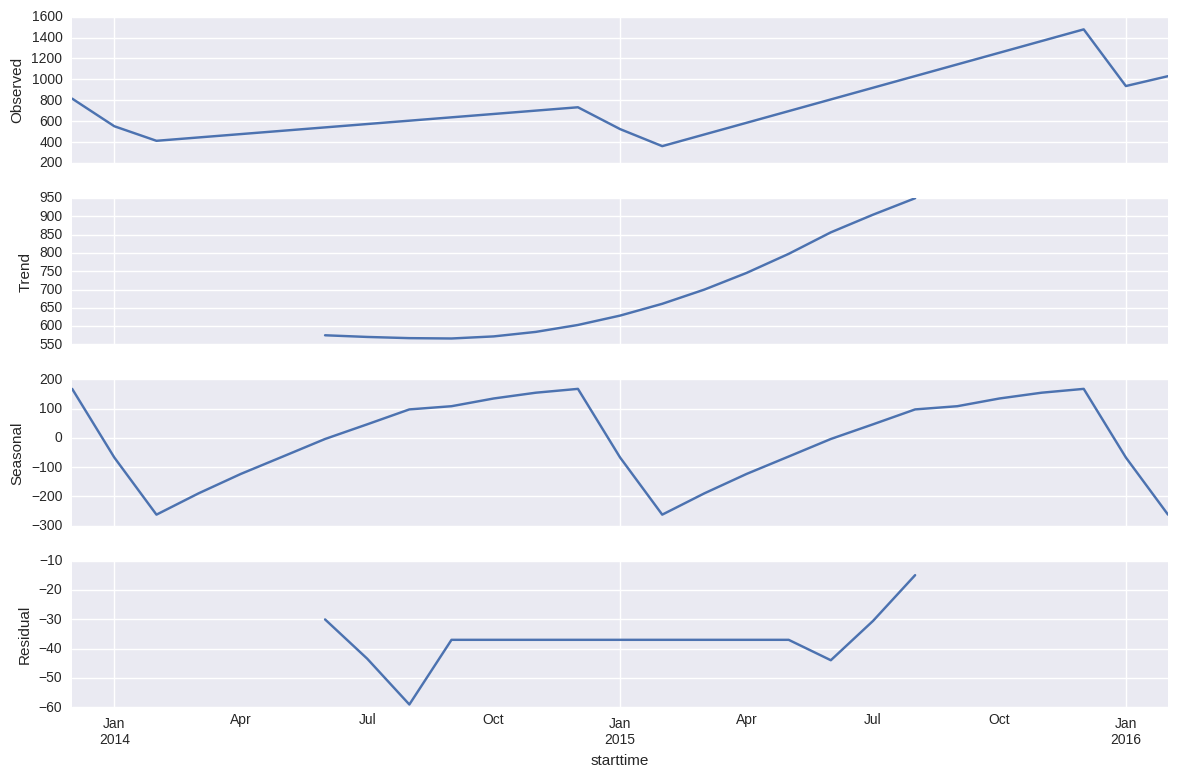

In [122]:
#Winter
#Create a monthly time series of bike ride (Average of all citibike stations)
df_new=winter_ride.mean(1).resample('M').mean()
df_new.interpolate(inplace=True)

#Seasonal Decomposition using statsmodels api
res = sm.tsa.seasonal_decompose(df_new.dropna())
plt.rcParams['figure.figsize']=(12,8)
resplot = res.plot()

### Map CitiBike Data to CT level
Load CitiBike station location data

In [126]:
station_id_summer=DataFrame.from_csv(os.getenv("PUIDATA")+ "/" + 'Station_id.csv')
#convert station_ids to string index
station_id_summer.index=station_id_summer.index.astype(str)
station_id_summer.head()

,lat,lon
1000,40.753231,-73.970325
1001,40.749718,-74.002950
1002,40.730287,-73.990765
1003,40.718939,-73.992663
1004,40.734927,-73.992005


In [127]:
station_id_winter=DataFrame.from_csv(os.getenv("PUIDATA")+ "/" + 'Station_id.csv')
#convert station_ids to string index
station_id_winter.index=station_id_winter.index.astype(str)
station_id_winter.head()

,lat,lon
1000,40.753231,-73.970325
1001,40.749718,-74.002950
1002,40.730287,-73.990765
1003,40.718939,-73.992663
1004,40.734927,-73.992005


### Create station gemotegry (lat and lon)

In [128]:
import shapely
# combine lat and lon to one column
station_id_summer['lonlat']=zip(station_id_summer.lon,station_id_summer.lat)
# Create Point Geometry for based on lonlat column
station_id_summer['geometry']=station_id_summer[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))
station_id_summer.head()

,lat,lon,lonlat,geometry
1000,40.753231,-73.970325,"(-73.97032517, 40.75323098)",POINT (-73.97032517 40.75323098)
1001,40.749718,-74.002950,"(-74.002950346, 40.749717753)",POINT (-74.00295034600001 40.749717753)
1002,40.730287,-73.990765,"(-73.9907647, 40.73028666)",POINT (-73.9907647 40.73028666)
1003,40.718939,-73.992663,"(-73.99266288, 40.71893904)",POINT (-73.99266288 40.71893904)
1004,40.734927,-73.992005,"(-73.99200509, 40.73492695)",POINT (-73.99200509000001 40.73492695)


In [129]:
import shapely
# combine lat and lon to one column
station_id_winter['lonlat']=zip(station_id_winter.lon,station_id_winter.lat)
# Create Point Geometry for based on lonlat column
station_id_winter['geometry']=station_id_winter[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))
station_id_winter.head()

,lat,lon,lonlat,geometry
1000,40.753231,-73.970325,"(-73.97032517, 40.75323098)",POINT (-73.97032517 40.75323098)
1001,40.749718,-74.002950,"(-74.002950346, 40.749717753)",POINT (-74.00295034600001 40.749717753)
1002,40.730287,-73.990765,"(-73.9907647, 40.73028666)",POINT (-73.9907647 40.73028666)
1003,40.718939,-73.992663,"(-73.99266288, 40.71893904)",POINT (-73.99266288 40.71893904)
1004,40.734927,-73.992005,"(-73.99200509, 40.73492695)",POINT (-73.99200509000001 40.73492695)


In [130]:
a=[]
# check for each citibike stations to see what CT they are belong to
for i in range(len(station_id_summer)):
    a.append(ct_shape[ct_shape.geometry.intersects(station_id_summer.iloc[i].geometry)].BoroCT2010.values[0])
    print '\r',"%",str((i+1)*100./len(station_id_summer))[:4],
station_id_summer['BoroCT2010']=a

% 100.


In [131]:
station_id_summer.BoroCT2010.head()

1000    1009000
1001    1009900
1002    1005700
1003    1001800
1004    1006100
Name: BoroCT2010, dtype: object

In [132]:
a=[]
# check for each citibike stations to see what CT they are belong to
for i in range(len(station_id_winter)):
    a.append(ct_shape[ct_shape.geometry.intersects(station_id_winter.iloc[i].geometry)].BoroCT2010.values[0])
    print '\r',"%",str((i+1)*100./len(station_id_winter))[:4],
station_id_winter['BoroCT2010']=a

% 100.


In [133]:
station_id_winter.BoroCT2010.head()

1000    1009000
1001    1009900
1002    1005700
1003    1001800
1004    1006100
Name: BoroCT2010, dtype: object

### Add mothly rides to station GeoDataFrame with CT code 

In [134]:
## Create average monthly rides column from monthly citibike data and add it to the station id which has the geometry
station_id_summer['MonthlyAve_summer']=summer_ride.sum()

In [136]:
station_id_summer.head()

,lat,lon,lonlat,geometry,BoroCT2010,MonthlyAve_summer
1000,40.753231,-73.970325,"(-73.97032517, 40.75323098)",POINT (-73.97032517 40.75323098),1009000,22422
1001,40.749718,-74.002950,"(-74.002950346, 40.749717753)",POINT (-74.00295034600001 40.749717753),1009900,32869
1002,40.730287,-73.990765,"(-73.9907647, 40.73028666)",POINT (-73.9907647 40.73028666),1005700,87375
1003,40.718939,-73.992663,"(-73.99266288, 40.71893904)",POINT (-73.99266288 40.71893904),1001800,33018
1004,40.734927,-73.992005,"(-73.99200509, 40.73492695)",POINT (-73.99200509000001 40.73492695),1006100,59890


In [137]:
station_id_winter['MonthlyAve_winter']=winter_ride.sum()

In [138]:
station_id_winter.head()

,lat,lon,lonlat,geometry,BoroCT2010,MonthlyAve_winter
1000,40.753231,-73.970325,"(-73.97032517, 40.75323098)",POINT (-73.97032517 40.75323098),1009000,9456
1001,40.749718,-74.002950,"(-74.002950346, 40.749717753)",POINT (-74.00295034600001 40.749717753),1009900,11373
1002,40.730287,-73.990765,"(-73.9907647, 40.73028666)",POINT (-73.9907647 40.73028666),1005700,36543
1003,40.718939,-73.992663,"(-73.99266288, 40.71893904)",POINT (-73.99266288 40.71893904),1001800,14170
1004,40.734927,-73.992005,"(-73.99200509, 40.73492695)",POINT (-73.99200509000001 40.73492695),1006100,21889


### Add the monthly average rides to the CT shapefile Winter and Summer rides

In [139]:
temp_summer=station_id_summer[['MonthlyAve_summer']]
temp_summer['station_id_summer']=station_id_summer.index
temp_summer.index=station_id_summer['BoroCT2010']
ct_shape_MonthlyAve_summer=ct_shape.join(temp_summer)
ct_shape_MonthlyAve_summer.fillna(0,inplace=True)

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


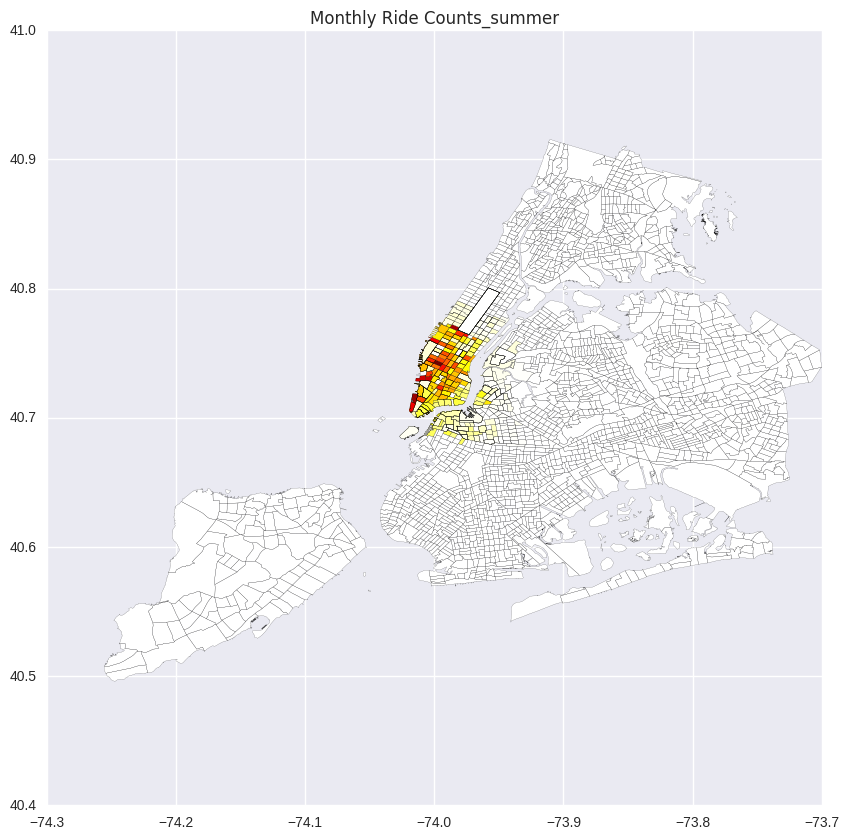

In [140]:
f, ax = plt.subplots(figsize=(10,10))
ct_shape_MonthlyAve_summer.plot(column='MonthlyAve_summer',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax)
plt.title("Monthly Ride Counts_summer")

In [141]:
temp_winter=station_id_winter[['MonthlyAve_winter']]
temp_winter['station_id_winter']=station_id_winter.index
temp_winter.index=station_id_winter['BoroCT2010']
ct_shape_MonthlyAve_winter=ct_shape.join(temp_winter)
ct_shape_MonthlyAve_winter.fillna(0,inplace=True)

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


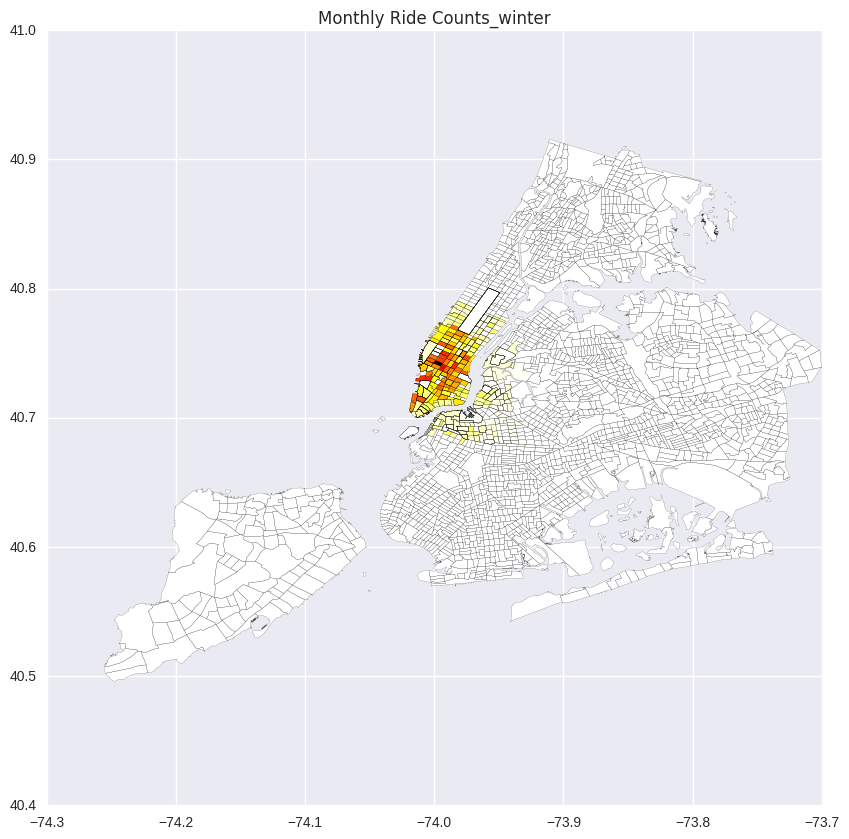

In [142]:
f, ax = plt.subplots(figsize=(10,10))
ct_shape_MonthlyAve_winter.plot(column='MonthlyAve_winter',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax)
plt.title("Monthly Ride Counts_winter")

### Removing the Census tracts that are out of the focus area 

In [143]:
ct_shape_MonthlyAve_summer_Zoom=(ct_shape_MonthlyAve_summer[ct_shape_MonthlyAve_summer
                           .centroid
                           .apply(lambda c:c.x>-74.1 and c.x<-73.92 and c.y>40.65 and c.y<40.8)])

In [144]:
print "Total number of CTs_summer:", len(ct_shape)
print "Number of zoomed CTs_summer:", len(temp_summer.MonthlyAve_summer)

Total number of CTs_summer: 2166
Number of zoomed CTs_summer: 543


In [146]:
ct_shape_MonthlyAve_winter_Zoom=(ct_shape_MonthlyAve_winter[ct_shape_MonthlyAve_winter
                           .centroid
                           .apply(lambda c:c.x>-74.1 and c.x<-73.92 and c.y>40.65 and c.y<40.8)])

In [147]:
print "Total number of CTs_winter:", len(ct_shape)
print "Number of zoomed CTs_winter:", len(temp_winter.MonthlyAve_winter)

Total number of CTs_winter: 2166
Number of zoomed CTs_winter: 543


### Map monthly rides in both winter and summer (zoomed)

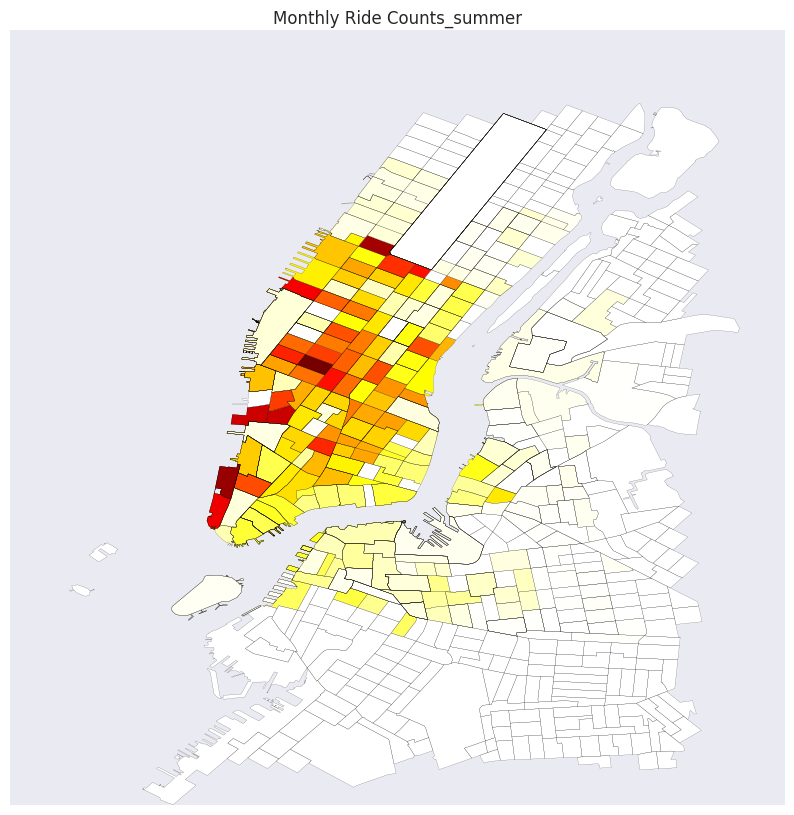

In [148]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape_MonthlyAve_summer_Zoom.plot(column='MonthlyAve_summer',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax)
plt.title("Monthly Ride Counts_summer")

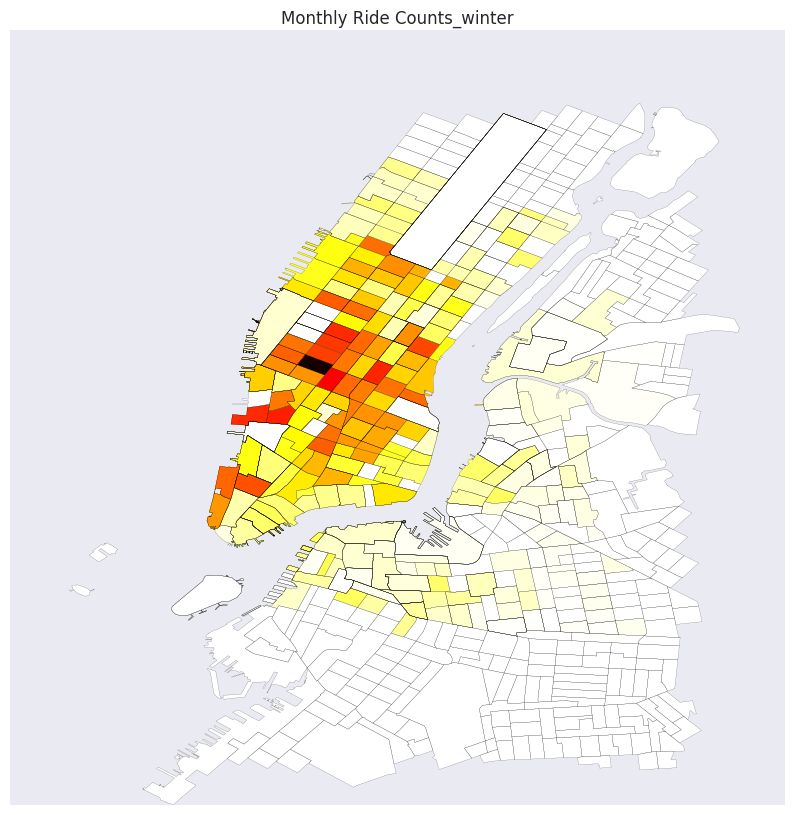

In [149]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape_MonthlyAve_winter_Zoom.plot(column='MonthlyAve_winter',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax)
plt.title("Monthly Ride Counts_winter")

Export Shapefile CTs in the Citibike zone 

In [151]:
path='ct_shape_MonthlyAve_Zoom.shp'
ct_shape_MonthlyAve_summer_Zoom.to_file(path)

In [152]:
import pysal as ps

In [153]:
qW_CT=ps.queen_from_shapefile(path)

Island id:  [0]


### Neighbors of index10

In [154]:
qW_CT[10]

{1: 1.0, 8: 1.0, 9: 1.0, 18: 1.0, 19: 1.0, 30: 1.0, 37: 1.0, 38: 1.0, 39: 1.0}

In [155]:
qW_CT.cardinalities[10]

9

### Matrix of Weights

In [156]:
Wmatrix, ids = qW_CT.full()

In [157]:
Wmatrix

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  1.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.]])

### Change the matrix to be row-standardized

In [158]:
qW_CT.transform = 'r'

### Spatial Lag

In [159]:
MonthlyRide_summer=ct_shape_MonthlyAve_summer_Zoom.MonthlyAve_summer
MonthlyRideLag_summer=ps.lag_spatial(qW_CT, MonthlyRide_summer)

In [160]:
MonthlyRide_winter=ct_shape_MonthlyAve_winter_Zoom.MonthlyAve_winter
MonthlyRideLag_winter=ps.lag_spatial(qW_CT, MonthlyRide_winter)

### Quantiles 

In [161]:
MonthlyRideLag_summerQ10 = ps.Quantiles(MonthlyRideLag_summer, k=10)
MonthlyRideLag_summerQ10

                   Quantiles                   
 
  Lower              Upper                Count
            x[i] <=     0.000               159
    0.000 < x[i] <=    49.286                 2
   49.286 < x[i] <=   882.900                78
  882.900 < x[i] <=  2346.833                80
 2346.833 < x[i] <=  5645.067                84
 5645.067 < x[i] <=  8593.933                75
 8593.933 < x[i] <= 19189.030                79
19189.030 < x[i] <= 27831.071                80
27831.071 < x[i] <= 32327.735                79
32327.735 < x[i] <= 49147.643                80

In [162]:
MonthlyRideLag_winterQ10 = ps.Quantiles(MonthlyRideLag_winter, k=10)
MonthlyRideLag_winterQ10

                   Quantiles                   
 
  Lower              Upper                Count
            x[i] <=     0.000               159
    0.000 < x[i] <=    36.286                 2
   36.286 < x[i] <=   603.729                78
  603.729 < x[i] <=  1458.923                80
 1458.923 < x[i] <=  2284.227                79
 2284.227 < x[i] <=  3278.714                80
 3278.714 < x[i] <=  7763.237                79
 7763.237 < x[i] <= 10456.870                80
10456.870 < x[i] <= 12783.385                79
12783.385 < x[i] <= 20551.286                80

### Map monthly rides lag 

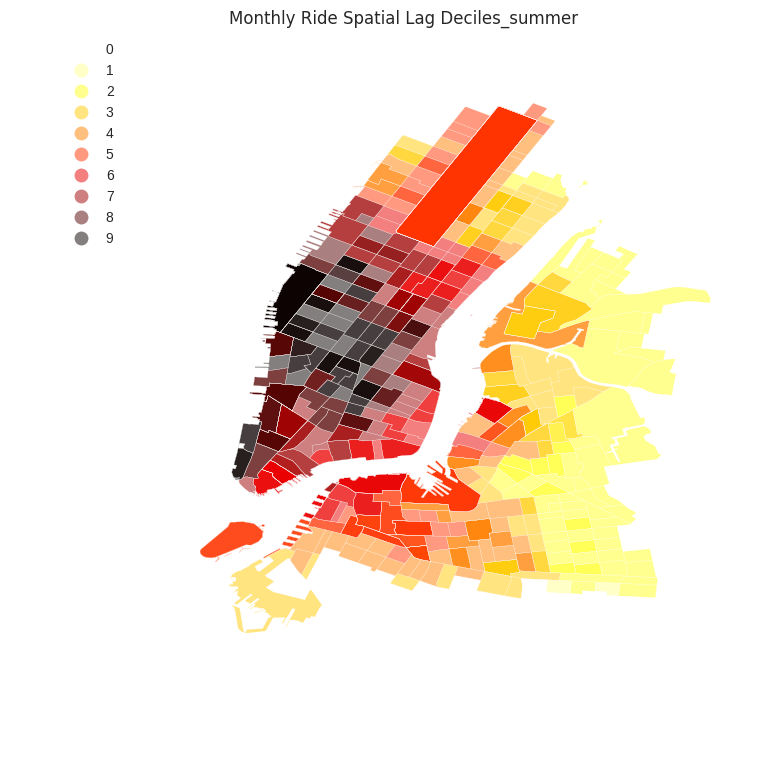

In [164]:
f, ax = plt.subplots(figsize=(9, 9))
ct_shape_MonthlyAve_summer_Zoom.assign(cl=MonthlyRideLag_summerQ10.yb).plot(column='cl', categorical=True, 
        k=10, cmap='hot_r', linewidth=0.1, ax=ax, 
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("Monthly Ride Spatial Lag Deciles_summer")

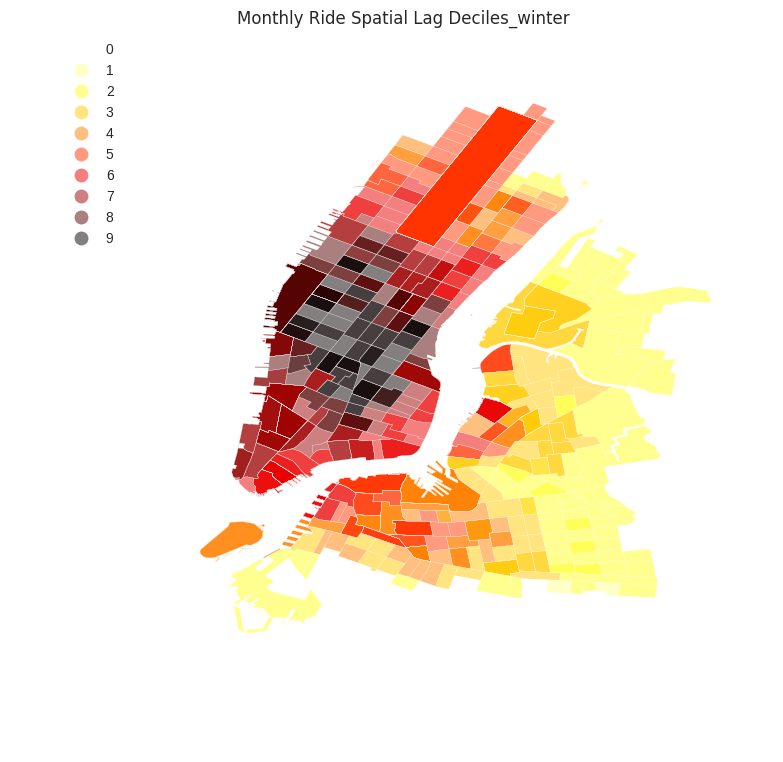

In [165]:
f, ax = plt.subplots(figsize=(9, 9))
ct_shape_MonthlyAve_winter_Zoom.assign(cl=MonthlyRideLag_winterQ10.yb).plot(column='cl', categorical=True, 
        k=10, cmap='hot_r', linewidth=0.1, ax=ax, 
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("Monthly Ride Spatial Lag Deciles_winter")


### Global Spatial Autocorrelation Winter and Summer rides

In [166]:
b_summer,a_summer = np.polyfit(MonthlyRide_summer, MonthlyRideLag_summer, 1)
b_summer,a_summer

(0.64335490815356511, 4220.5552980795601)

In [167]:
b_winter,a_winter = np.polyfit(MonthlyRide_winter, MonthlyRideLag_winter, 1)
b_winter,a_winter

(0.66023249858156818, 1600.8324238675889)

### Moran Scatterplot

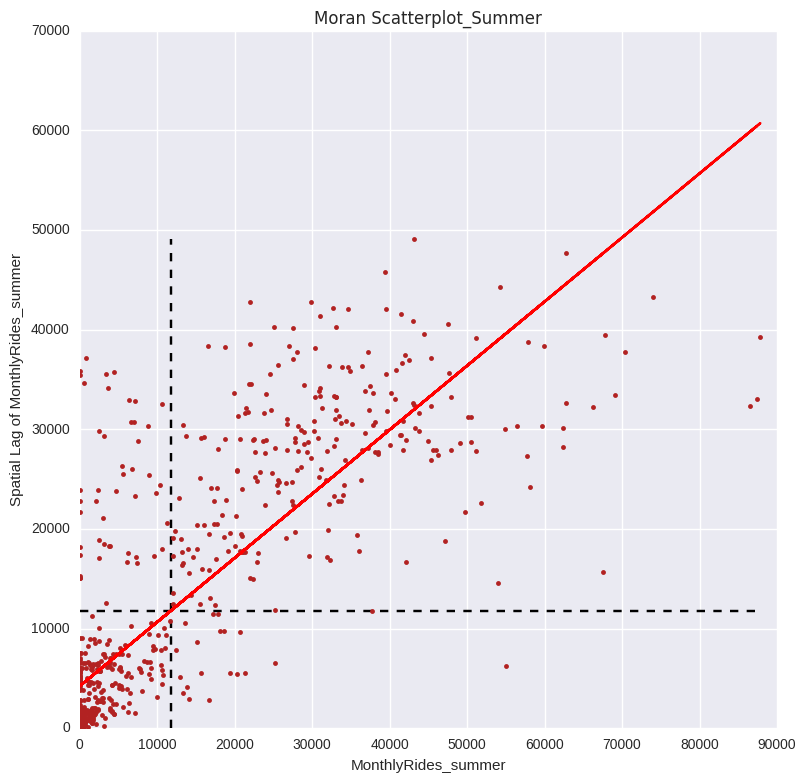

In [168]:
f, ax = plt.subplots(1, figsize=(9, 9))

plt.plot(MonthlyRide_summer, MonthlyRideLag_summer, '.', color='firebrick')

 # dashed vert at mean of the last year's PCI
plt.vlines(MonthlyRide_summer.mean(), MonthlyRideLag_summer.min(), MonthlyRideLag_summer.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(MonthlyRideLag_summer.mean(), MonthlyRide_summer.min(), MonthlyRide_summer.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(MonthlyRide_summer, a_summer + b_summer*MonthlyRide_summer, 'r')
plt.title('Moran Scatterplot_Summer')
plt.ylabel('Spatial Lag of MonthlyRides_summer')
plt.xlabel('MonthlyRides_summer')

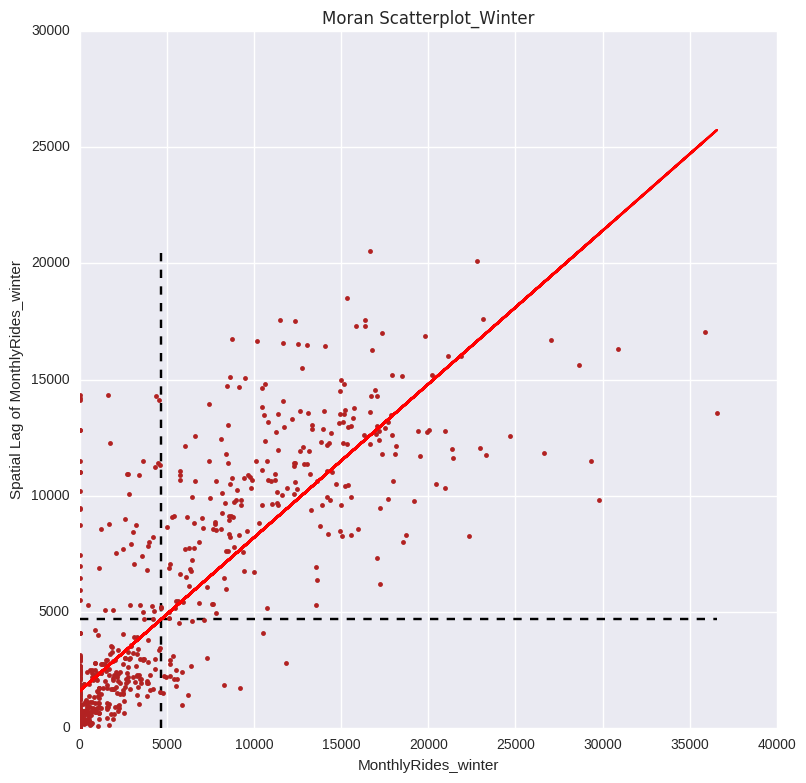

In [169]:
f, ax = plt.subplots(1, figsize=(9, 9))

plt.plot(MonthlyRide_winter, MonthlyRideLag_winter, '.', color='firebrick')

 # dashed vert at mean of the last year's PCI
plt.vlines(MonthlyRide_winter.mean(), MonthlyRideLag_winter.min(), MonthlyRideLag_winter.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(MonthlyRideLag_winter.mean(), MonthlyRide_winter.min(), MonthlyRide_winter.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(MonthlyRide_winter, a_winter + b_winter*MonthlyRide_winter, 'r')
plt.title('Moran Scatterplot_Winter')
plt.ylabel('Spatial Lag of MonthlyRides_winter')
plt.xlabel('MonthlyRides_winter')

### Moran's I

In [182]:
I_MonthlyRide_summer = ps.Moran(MonthlyRide_summer, qW_CT)

In [183]:
I_MonthlyRide_summer.I, I_MonthlyRide_summer.p_sim

(0.64353398667011008, 0.001)

Thus, the $I$ statistic for summer rides is $0.643$ for this data, and has a very small $p$ value.


In [184]:
I_MonthlyRide_summer.sim[0:10]

array([-0.00661045, -0.03185961,  0.00888179,  0.00869362, -0.02024552,
       -0.0032241 ,  0.0408597 , -0.00503726,  0.02191081,  0.00715051])

In [185]:
I_MonthlyRide_winter = ps.Moran(MonthlyRide_winter, qW_CT)

In [186]:
I_MonthlyRide_winter.I, I_MonthlyRide_winter.p_sim

(0.66039156431885593, 0.001)

Thus, the $I$ statistic for winter rides is $0.660$ for this data, and has a very small $p$ value.


In [187]:
I_MonthlyRide_winter.sim[0:10]

array([-0.01785989, -0.00671656, -0.00362082, -0.00194208,  0.00533651,
       -0.01371556, -0.02194656,  0.00555542,  0.00055089,  0.00504762])

### KDEplot of all of the simulated points
the vertical line shows the observed value

In [188]:
import seaborn as sns
plt.rcParams['figure.figsize']=(14,3)

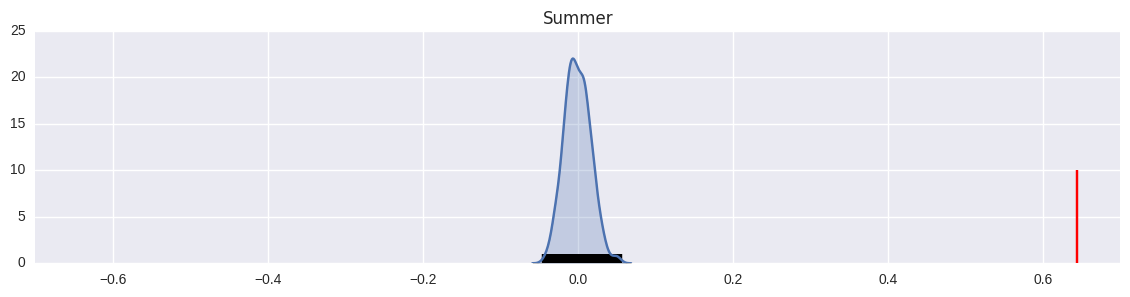

In [189]:
sns.kdeplot(I_MonthlyRide_summer.sim, shade=True)
plt.vlines(I_MonthlyRide_summer.sim, 0, 1)
plt.vlines(I_MonthlyRide_summer.I, 0, 10, 'r')
plt.xlim([-.70, .70])
plt.title('Summer')

In the following figure the vertical line is showing if our $I$ statistic were close to our expected value


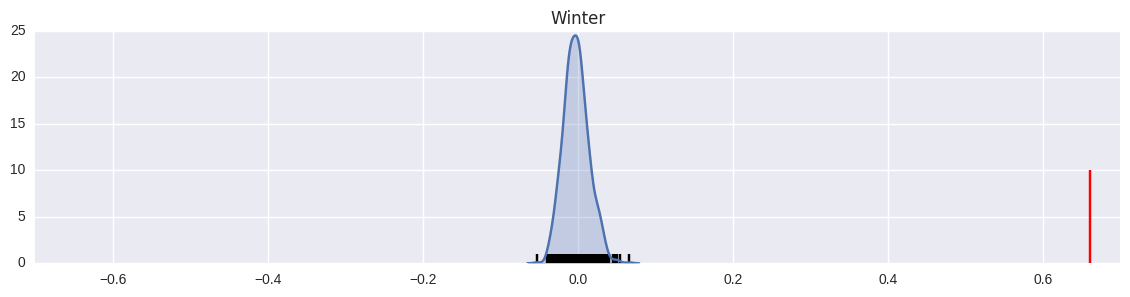

In [190]:
sns.kdeplot(I_MonthlyRide_winter.sim, shade=True)
plt.vlines(I_MonthlyRide_winter.sim, 0, 1)
plt.vlines(I_MonthlyRide_winter.I, 0, 10, 'r')
plt.xlim([-.70, .70])
plt.title('Winter')

In the following figure the vertical line is showing if our $I$ statistic were close to our expected value

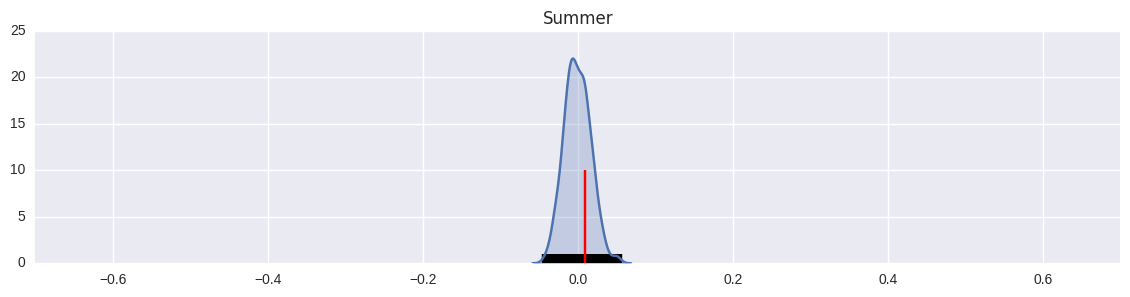

In [191]:
sns.kdeplot(I_MonthlyRide_summer.sim, shade=True)
plt.vlines(I_MonthlyRide_summer.sim, 0, 1)
plt.vlines(I_MonthlyRide_summer.EI+.01, 0, 10, 'r')
plt.xlim([-.70, .70])
plt.title('Summer')

In the following figure the vertical line is showing when I statistic is close to our expected value

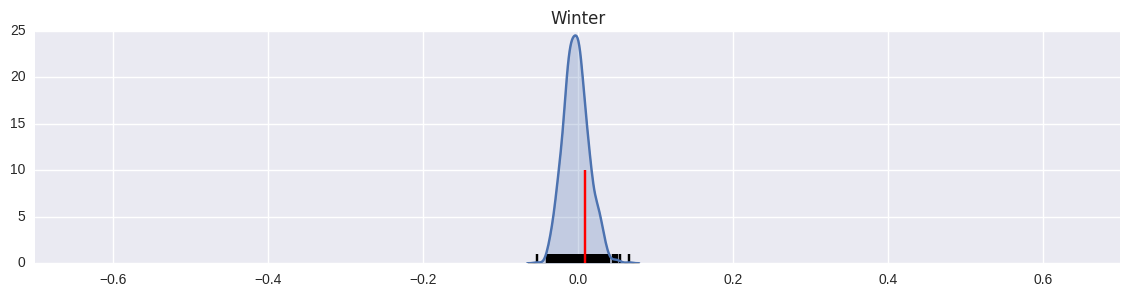

In [192]:
sns.kdeplot(I_MonthlyRide_winter.sim, shade=True)
plt.vlines(I_MonthlyRide_winter.sim, 0, 1)
plt.vlines(I_MonthlyRide_winter.EI+.01, 0, 10, 'r')
plt.xlim([-.70, .70])
plt.title('Winter')

In the following figure the vertical line is showing when I statistic is close to our expected value
